# FFT exercises

[npy file format](https://www.numpy.org/devdocs/reference/generated/numpy.lib.format.html)

[npz file format (save several arrays)](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.savez.html)

[article about advantages of npy/npz format compared to csv and other common formats](https://towardsdatascience.com/why-you-should-start-using-npy-file-more-often-df2a13cc0161)

## First import data from eeg_data00.npz

In [1]:
# first import the modules that you'll need. 
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

## load eeg_data00.npz...
* you should find that it has three arrays: data, tx, and sr (with 'data' a #trials x # timepoints array containing the EEG data, the time of each data acquisition in tx, and the sample rate stored as sr).  
* Note that you'll need the `sr` variable to comput `dt` (timesteps between samples) to pass to `np.fft.rfftfreq` to generate x-axes to plot the results of FFTs that you perform on the data

In [2]:
# load the data...
eeg = np.load('eeg_data00.npz')

# get the different arrays - dictionary structure, so access with keys 'data', 'sr', 'tx'
# eeg['data']
# eeg['sr']
# eeg['tx']

# and can query the attributes of the data like this...
# which will tell us that there 960 trials and 876 timepoints per trial sampled
# at 250Hz
print('Shape of the eeg data set: ', eeg['data'].shape)
print('Sample rate: ', eeg['sr'])

# and if you want to save some typing, especially because we only have a few variables, 
# you can reassign the different arrays like this
data = eeg['data']
sr = eeg['sr']
tx = eeg['tx']


Shape of the eeg data set:  (960, 876)
Sample rate:  250


## First - plot the data! (always do this first). 
* Remember, `data` is a 2D matrix with trials (repeats) in the first dimension and timepoints as the second dimension
* Compute the mean across all trials and then plot with tx on the xaxis
* Remember - good form is to explicitly specify the axis that you want to average over when using np.mean, so think about what dimension you need to average over. 

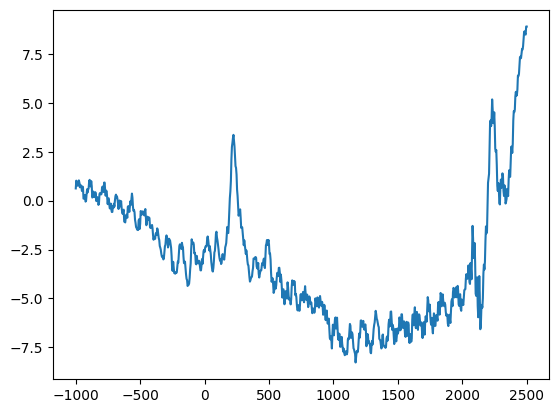

In [3]:
mean_val = np.mean(data, axis=0)
mean_val.shape
plt.plot(tx, mean_val)
plt.show()

## Now grab the data from time 0 until time 2000 and plot it then FFT it..
* Use boolean indexing by selecting the columns from the 'data' matrix where tx>=0  & tx<2000...remember the rules about using `()` around conditional arguments when doing boolean indexing to avoid ambigous outputs. 
* while you're at it, go ahead and make an array of the timepoints 0...1999 for use as an x-axis label while plotting by boolean indexing into `tx`
* Now plot the timeseries to make sure it looks right (compare with plot of entire timeseries above)

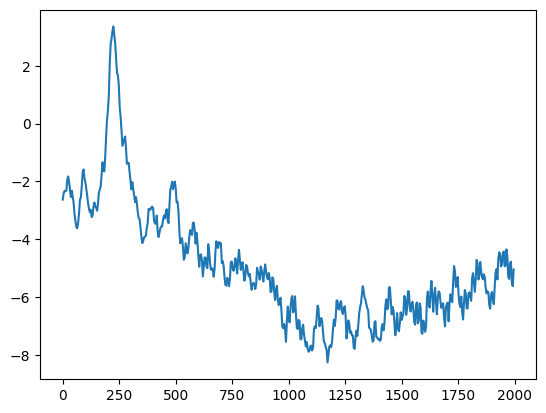

In [4]:
select_data = mean_val[(tx>=0)&(tx<2000)]
select_time = tx[(tx>=0)&(tx<2000)]
plt.plot(select_time, select_data)
plt.show()

## Do the FFT on the data averaged across trials (so first avg the data across trials, and then FFT)
* Plot the FFT amplitudes after you run it
* Make sure you generate a frequency axis to plot the data on...use `np.fft.rfftfreq`

In [5]:
sr = eeg['sr']
1/sr

0.004

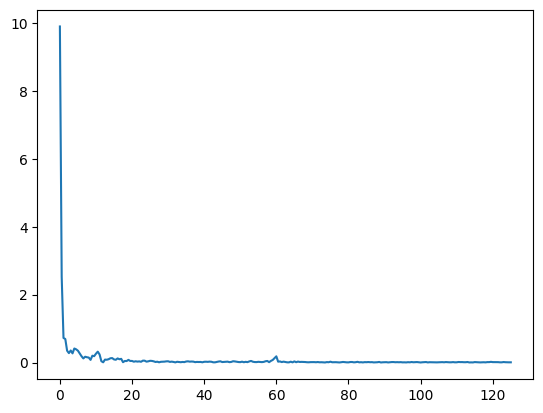

In [6]:
dt = tx[1] - tx[0]

op = np.fft.rfft(select_data)
amps = 2*(np.abs(op)/select_data.size)

freq = np.fft.rfftfreq(select_data.size, 1/sr)

plt.plot(freq, amps)
plt.show()

## Now lets look at a few frequency segments to see what is going on
* First plot just the frequencies in between 55 and 65Hz (use boolean indexing)
* Then look at the frequencies in between 5 and 20Hz

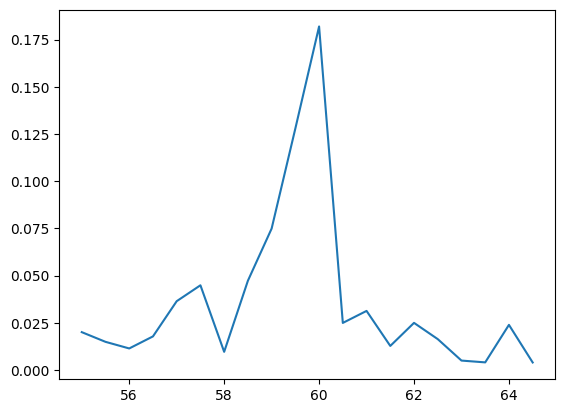

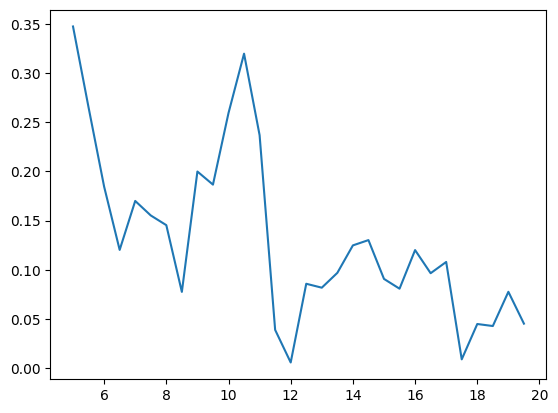

In [7]:
select_freq = freq[(freq>=55) & (freq <65)]
select_amps = amps[(freq>=55) & (freq <65)]

plt.plot(select_freq, select_amps)
plt.show()

select_freq = freq[(freq>=5) & (freq <20)]
select_amps = amps[(freq>=5) & (freq <20)]

plt.plot(select_freq, select_amps)
plt.show()

## You should see line noise (or 60hz oscillations induced by the electrical current in the building) and alpha oscillations (a huge brain osciallation that is easy to record with scalp electrodes)...

## Remember what the above plots look like, and then do something that *seems* just a little different
* FFT each trial 
* Then compute the amplitude on each trial (np.abs)
* Then compute the average amplitude across all trials
* Then plot like you did above - first over all frequs, then zoom in and plot the 55-65hz window and the 5-20Hz window 
* To make this work, note that np.fft.rfft can operate on the entire data matrix at once. You should ALWAYS specify the axis that you want the FFT to work over (in this case the time axis, or axis = 1). np.fft.rfft will default to the LAST axis if you specify nothing, which in this case is ok but it would totally NOT be ok if your data were transposed!!!
* Hint: handy to store the shape of the data matrix before you do all this so that you can pass in the number of timepoints to the amplitude normalization function and the freq-axis function. e.g. r,c = data.shape

[np.fft.rfft documentation](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.fft.rfft.html)

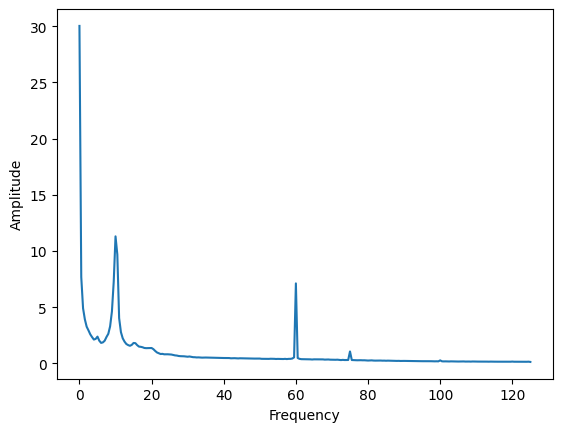

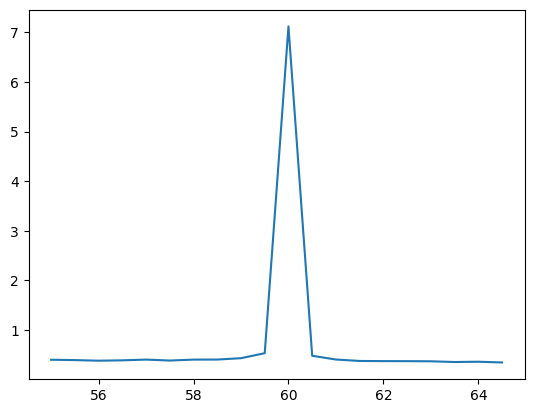

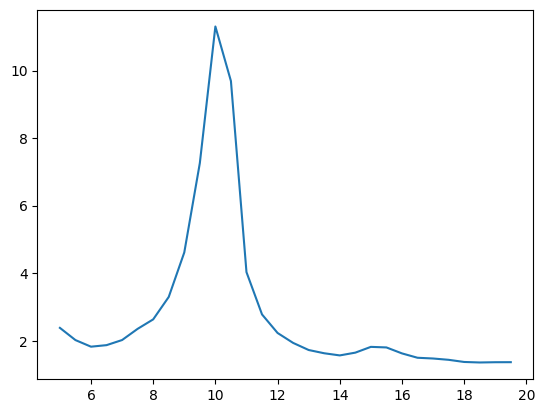

In [8]:
select_data = data[:, ((tx>=0)&(tx<2000))]

cplx_trail_freq = np.fft.rfft(select_data, axis=1)
trail_amps = 2*(np.abs(cplx_trail_freq)/select_data.shape[1])
trail_freq = np.fft.rfftfreq(select_data.shape[1], 1/sr)

mean_trail_amps = np.mean(trail_amps, axis=0)
# mean_trail_amps.shape

plt.plot(trail_freq, mean_trail_amps)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

select_trail_freq = trail_freq[(trail_freq>=55) & (trail_freq <65)]
select_trail_amps = mean_trail_amps[(trail_freq>=55) & (trail_freq <65)]

plt.plot(select_trail_freq, select_trail_amps)
plt.show()

select_trail_freq = trail_freq[(trail_freq>=5) & (trail_freq <20)]
select_trail_amps = mean_trail_amps[(trail_freq>=5) & (trail_freq <20)]

plt.plot(select_freq, select_trail_amps)
plt.show()

In [9]:
mean_trail_amps[0]

30.023420237520973

## Challenge question
* We just learned that a FFT is a transform of a time domain signal into a frequency domain representation. 
* Suppose you wanted to clean up this data set by removing the 60Hz line noise that we plotted above...
* Think about how you would design a filter to selectively zero out the 60Hz power in the frequency domain, and then transform that filtered data back into the time domain. 
    * Hint: What vector could you multiply the frequency domain data by that would 'pass' (or leave unaffected) all of the values except those around 60Hz, which would be zeroed out?
    * Hint 2: Whatever filter you apply, you need to apply it to the complex-valued frequency domain data, not just the amplitudes (i.e. not just the `np.abs` of the data), before you `np.fft.irfft`. This is critical because the amplitude does not contain the phase angle (i.e. the angular rotation around that real/imaginary plane we talked about at the start of the class)

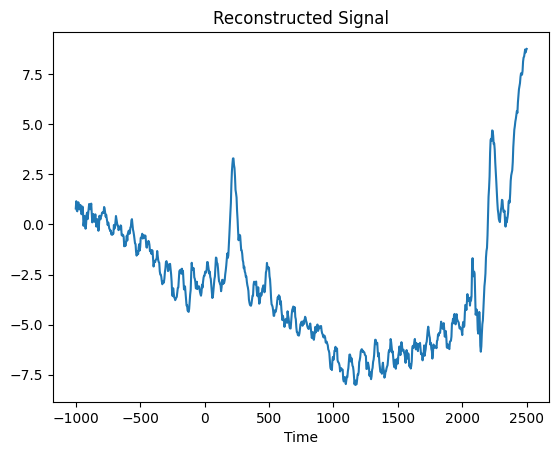

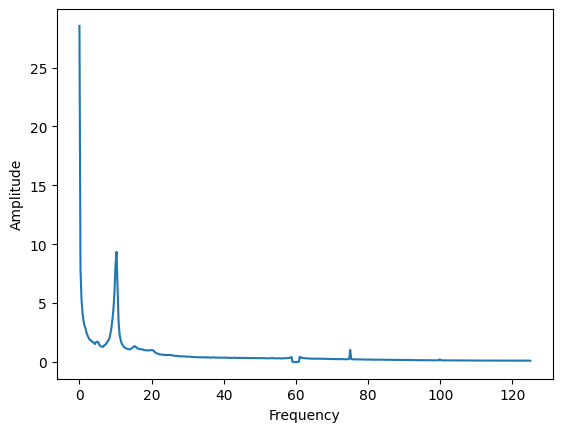

(251,) (960, 439) (960, 876)


In [10]:
cplx_op = np.fft.rfft(data, axis=1)
trail_amps = 2*(np.abs(cplx_op)/data.shape[1])
trail_freq = np.fft.rfftfreq(data.shape[1], 1/sr)

fltr = (trail_freq <= 59) | (trail_freq >= 61)
band_pass = cplx_op*fltr

cleaned_recons = np.fft.irfft(band_pass, axis=1)
mean_recons = np.mean(cleaned_recons, axis=0)
plt.plot(tx, mean_recons)
plt.xlabel("Time")
plt.title("Reconstructed Signal")
plt.show()

cplx_op = np.fft.rfft(cleaned_recons, axis=1)
trail_amps = 2*(np.abs(cplx_op)/data.shape[1])
trail_freq = np.fft.rfftfreq(cleaned_recons.shape[1], 1/sr)
mean_amps = np.mean(trail_amps, axis=0)

plt.plot(trail_freq, mean_amps)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()


print(freq.shape, band_pass.shape, cleaned_recons.shape)